In [1]:
from google.colab import drive
import os
import torch
import torch.nn as nn
import torchvision.transforms as T
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from matplotlib import pyplot as plt
import random
import torch.optim as optim
import time

In [2]:
print(f"CUDA is available? {torch.cuda.is_available()}")
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(dev)

CUDA is available? True
cuda


In [3]:
drive.mount("/content/drive",True)
root_dir = "/content/drive/My Drive/SB3/"

Mounted at /content/drive


In [4]:
train_transform = T.Compose([
    T.Resize(256),
    T.ToTensor()
])

In [5]:
train_dataset = ImageFolder(os.path.join(root_dir, "train"), transform=train_transform)
test_dataset = ImageFolder(os.path.join(root_dir, "test"), transform=train_transform)
num_classes = len(train_dataset.classes)
print(num_classes)

8


In [6]:
num_train = len(train_dataset)
train_idx = list(range(num_train))
random.shuffle(train_idx)
val_frac = 0.2
num_val = int(num_train*val_frac)
num_train = num_train - num_val
val_idx = train_idx[num_train:]
train_idx = train_idx[:num_train]
val_dataset = Subset(train_dataset,val_idx)
train_dataset = Subset(train_dataset, train_idx)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=4, num_workers=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, num_workers=4, shuffle=False)
test_loader = DataLoader(test_dataset,   batch_size=4, num_workers=4, shuffle=False)
loaders = {
    "train": train_loader,
    "val" : val_loader,
    "test": test_loader
}

In [9]:
class ConvCapsLayer(nn.Module):
    def __init__(self, in_channel_types, out_channel_types, in_vector_length, out_vector_length, kernel_size, padding, stride, num_iterations, new_height, new_width):
      super().__init__()
      
      self.in_channel_types = in_channel_types
      self.out_channel_types = out_channel_types
      self.in_vector_length = in_vector_length
      self.out_vector_length = out_vector_length
      self.kernel_size = kernel_size
      self.padding = padding
      self.stride = stride
      self.num_iterations = num_iterations
      self.new_height = new_height
      self.new_width = new_width
      self.W = nn.Parameter(torch.randn(1, in_channel_types, 1, out_channel_types, out_vector_length, in_vector_length))
    
    def squash(self, in_tensor):
      squared_norm = (in_tensor ** 2).sum(-2, keepdim=True)
      out_tensor = squared_norm *  in_tensor / ((1. + squared_norm) * torch.sqrt(squared_norm) + 1e-10)
      return out_tensor

    def forward(self, x):
      batch_size = x.size(0)
      y = torch.zeros(batch_size, self.in_vector_length, self.in_channel_types, self.new_height, self.new_width, dtype=torch.float).to(dev)
      kernel = torch.ones(1, 1, self.kernel_size, self.kernel_size, dtype=torch.float).to(dev)
      for i in range(self.in_vector_length):
        for j in range(self.in_channel_types):
          y[:,i,j,:,:] = F.conv2d(x[:,i,j,:,:].unsqueeze_(1), kernel, padding=self.padding, stride=self.stride).squeeze(1)

      y = y.view(batch_size, self.in_channel_types, self.new_height * self.new_width, -1)
      y = torch.stack([y] * self.out_channel_types, dim=3).unsqueeze(5)

      W = torch.cat([self.W] * batch_size, dim=0)
      c = W @ y

      b_ij = torch.zeros(1, self.in_channel_types, c.size(2), self.out_channel_types, 1).to(dev)

      for iteration in range(self.num_iterations):
        c_ij = F.softmax(b_ij, dim=-2)
        c_ij = torch.cat([c_ij] * batch_size, dim=0).unsqueeze(5)

        s_j = (c_ij * c).sum(dim=1, keepdim=True)
        v_j = self.squash(s_j)

        if iteration < self.num_iterations - 1:
          a_ij = torch.matmul(c.transpose(4, 5), torch.cat([v_j] * self.in_channel_types, dim=1))
          b_ij = b_ij + a_ij.squeeze(5).mean(dim=0, keepdim=True)

      v_j = v_j.squeeze(1)
      v_j = v_j.transpose(3,1).squeeze(4)
      v_j = v_j.view(v_j.size(0), v_j.size(1), v_j.size(2), self.new_height, self.new_width)
      return v_j

In [10]:
class Reconstruction(nn.Module):
    def __init__(self, num_classes):
      super().__init__()
      
      self.fc_layer = nn.Sequential(
        nn.Linear(num_classes*16, 64),
        nn.ReLU()
      )

      self.reconstruction_layers = nn.Sequential(
          nn.ConvTranspose2d(1, 128, kernel_size=5, padding=2, stride=9),
          nn.ReLU(),
          nn.ConvTranspose2d(128, 64, kernel_size=5, padding=1, stride=4, output_padding=(1,1)),
          nn.ReLU(),
          nn.Conv2d(64, 3, kernel_size=5, padding=2, stride=1),
          nn.ReLU()
    )
        
    def forward(self, x):
        x = self.fc_layer(x)
        x = x.view(x.size(0), 1, 8, 8)
        x = self.reconstruction_layers(x)
        return x

In [11]:
class CapsNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2, stride=2),
            nn.ReLU()
        )
        
        self.conv_capsule_layers = nn.Sequential(
            ConvCapsLayer(in_channel_types = 1, out_channel_types = 2, in_vector_length = 16, out_vector_length = 16, kernel_size = 5, padding = 2, stride = 2, num_iterations = 1, new_height = 64, new_width = 64),
            ConvCapsLayer(in_channel_types = 2, out_channel_types = 4, in_vector_length = 16, out_vector_length = 16, kernel_size = 5, padding = 2, stride = 1, num_iterations = 3, new_height = 64, new_width = 64),
            ConvCapsLayer(in_channel_types = 4, out_channel_types = 4, in_vector_length = 16, out_vector_length = 32, kernel_size = 5, padding = 2, stride = 2, num_iterations = 3, new_height = 32, new_width = 32),
            ConvCapsLayer(in_channel_types = 4, out_channel_types = 8, in_vector_length = 32, out_vector_length = 32, kernel_size = 5, padding = 2, stride = 1, num_iterations = 3, new_height = 32, new_width = 32),
            ConvCapsLayer(in_channel_types = 8, out_channel_types = 8, in_vector_length = 32, out_vector_length = 64, kernel_size = 5, padding = 2, stride = 2, num_iterations = 3, new_height = 16, new_width = 16),
            ConvCapsLayer(in_channel_types = 8, out_channel_types = 8, in_vector_length = 64, out_vector_length = 32, kernel_size = 5, padding = 2, stride = 1, num_iterations = 3, new_height = 16, new_width = 16),
            ConvCapsLayer(in_channel_types = 8, out_channel_types = num_classes, in_vector_length = 32, out_vector_length = 16, kernel_size = 5, padding = 2, stride = 2, num_iterations = 3, new_height = 8, new_width = 8)
        )

        self.reconstruction_layer = Reconstruction(num_classes)

    def capsule_average_pooling(self, x):
      height = x.size(3)
      width = x.size(4)
      x = x.sum(dim=4).sum(dim=3)
      x = x / (height * width)
      return x
    
    def score(self, x):
      return torch.sqrt((x ** 2).sum(dim=2))
    
    def forward(self, x):
      x = self.conv_layers(x)
      x = x.unsqueeze(2)
      x = self.conv_capsule_layers(x)
      x = x.transpose(1, 2)
      x = self.capsule_average_pooling(x)
      scores = self.score(x)
      x = x.view(x.size(0), x.size(1) * x.size(2))
      reconstructions = self.reconstruction_layer(x)
      return scores, reconstructions

In [12]:
model = CapsNet(num_classes=num_classes)
model = model.to(dev)

In [16]:
batch,labels = next(iter(train_loader))
batch = batch.to(dev)
labels = labels.to(dev)
scores, reconstructions = model(batch)
print(scores)

tensor([[0.0754, 0.1455, 0.1450, 0.1161, 0.0988, 0.0928, 0.1148, 0.0928],
        [0.0689, 0.1424, 0.1332, 0.1143, 0.0950, 0.0961, 0.1176, 0.0782],
        [0.0666, 0.1344, 0.1396, 0.1363, 0.1009, 0.0987, 0.1011, 0.1087],
        [0.0622, 0.1383, 0.1321, 0.1266, 0.0993, 0.0807, 0.1244, 0.0980]],
       device='cuda:0', grad_fn=<SqrtBackward>)


In [19]:
def train(epochs, dev, lr=0.001):
    try:
        # Create model
        model = CapsNet(num_classes=8)
        model = model.to(dev)
        # Optimizer
        optimizer = optim.SGD(model.parameters(), lr=lr)
        # Initialize history
        history_loss = {"train": [], "val": [], "test": []}
        history_accuracy = {"train": [], "val": [], "test": []}
        # Process each epoch
        for epoch in range(epochs):
            # Initialize epoch variables
            sum_loss = {"train": 0, "val": 0, "test": 0}
            sum_accuracy = {"train": 0, "val": 0, "test": 0}
            
            # Process each split
            for split in ["train", "val", "test"]:
                # Process each batch
                for (input, labels) in loaders[split]:
                    # Move to CUDA
                    input = input.to(dev)
                    labels = labels.to(dev)
                    # Reset gradients
                    optimizer.zero_grad()
                    # Compute output
                    pred, reconstructions = model(input)
                    print(pred)
                    score_loss = F.cross_entropy(pred, labels)
                    reconstruction_loss = F.mse_loss(input, reconstructions)
                    loss = score_loss + reconstruction_loss
                    # Update loss
                    sum_loss[split] += loss.item()
                    # Check parameter update
                    if split == "train":
                        # Compute gradients
                        score_loss.backward()
                        # Optimize
                        optimizer.step()
                    # Compute accuracy
                    _,pred_labels = pred.max(1)
                    batch_accuracy = (pred_labels == labels).sum().item()/input.size(0)
                    # Update accuracy
                    sum_accuracy[split] += batch_accuracy
            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            # Update history
            for split in ["train", "val", "test"]:
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
            # Print info
            print(f"Epoch {epoch+1}:",
                  f"TrL={epoch_loss['train']:.4f},",
                  f"TrA={epoch_accuracy['train']:.4f},",
                  f"VL={epoch_loss['val']:.4f},",
                  f"VA={epoch_accuracy['val']:.4f},",
                  f"TeL={epoch_loss['test']:.4f},",
                  f"TeA={epoch_accuracy['test']:.4f},"
                )
    except KeyboardInterrupt:
        print("Interrupted")
    finally:
        # Plot loss
        plt.title("Loss")
        for split in ["train", "val", "test"]:
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()
        # Plot accuracy
        plt.title("Accuracy")
        for split in ["train", "val", "test"]:
            plt.plot(history_accuracy[split], label=split)
        plt.legend()
        plt.show()

tensor([[0.1201, 0.1327, 0.0952, 0.1361, 0.0907, 0.0844, 0.0987, 0.1269],
        [0.1257, 0.1408, 0.0839, 0.1458, 0.1031, 0.0853, 0.0908, 0.1248],
        [0.1254, 0.1471, 0.0864, 0.1379, 0.1002, 0.0761, 0.0898, 0.1264],
        [0.1299, 0.1378, 0.0983, 0.1361, 0.0936, 0.0762, 0.0918, 0.1182]],
       device='cuda:0', grad_fn=<SqrtBackward>)
tensor([[nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan]], device='cuda:0',
       grad_fn=<SqrtBackward>)
tensor([[nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan]], device='cuda:0',
       grad_fn=<SqrtBackward>)
Interrupted


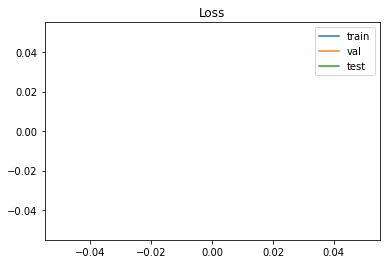

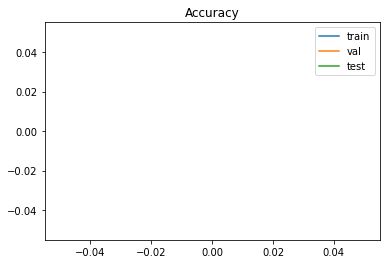

In [20]:
train(100, dev)